In [ ]:
from google.colab import drive
import os
import zipfile


drive.mount('/content/drive')



zip_path = '/content/drive/MyDrive/pcb-defect-dataset.zip'


print("Dosyalar çıkarılıyor, lütfen bekle...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print(" Zip çıkarma işlemi tamamlandı!")

Mounted at /content/drive
Dosyalar çıkarılıyor, lütfen bekle...
 Zip çıkarma işlemi tamamlandı!


In [ ]:
import os
import cv2
import shutil


base_dataset_path = "/content/pcb-defect-dataset"
output_dataset_path = "/content/resnet_data"

# class'lar
classes = [
    "mouse_bite",       # 0
    "spur",             # 1
    "missing_hole",     # 2
    "short",            # 3
    "open_circuit",     # 4
    "spurious_copper"   # 5
]
# ---------------

def process_data(split_type):
    print(f" {split_type.upper()} klasörü işleniyor...")

    img_dir = os.path.join(base_dataset_path, split_type, "images")
    lbl_dir = os.path.join(base_dataset_path, split_type, "labels")
    out_dir = os.path.join(output_dataset_path, split_type)

    if not os.path.exists(img_dir):
        print(f" Klasör bulunamadı: {img_dir}")
        return


    for cls in classes:
        os.makedirs(os.path.join(out_dir, cls), exist_ok=True)

    count = 0
    txt_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]

    for txt_file in txt_files:
        base_name = os.path.splitext(txt_file)[0]


        img_path = os.path.join(img_dir, base_name + ".jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(img_dir, base_name + ".png")
            if not os.path.exists(img_path): continue

        img = cv2.imread(img_path)
        if img is None: continue
        h_img, w_img = img.shape[:2]


        with open(os.path.join(lbl_dir, txt_file), 'r') as f:     # etikete eriş
            lines = f.readlines()

        for i, line in enumerate(lines):
            try:                                 # veri ayırma
                data = line.strip().split()
                cls_id = int(data[0])
                if cls_id >= len(classes): continue

                x_c, y_c, w, h = map(float, data[1:])   # kordinat al

                 # piksel hesabı
                x1 = int((x_c - w/2) * w_img)
                y1 = int((y_c - h/2) * h_img)
                x2 = int((x_c + w/2) * w_img)
                y2 = int((y_c + h/2) * h_img)


                x1, y1 = max(0, x1), max(0, y1)                 # sınır düzeltme
                x2, y2 = min(w_img, x2), min(h_img, y2)

                crop = img[y1:y2, x1:x2]              #kesme işlemi


                if crop.size == 0 or w < 0.01 or h < 0.01: continue


                save_name = f"{base_name}_crop_{i}.jpg"               #kaydet
                save_path = os.path.join(out_dir, classes[cls_id], save_name)
                cv2.imwrite(save_path, crop)
                count += 1
            except: pass

    print(f" {split_type} tamamlandı: {count} resim kesildi.")


process_data("train")   # başla
process_data("val")


✂️ TRAIN klasörü işleniyor...
 train tamamlandı: 12991 resim kesildi.
✂️ VAL klasörü işleniyor...
 val tamamlandı: 1595 resim kesildi.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


train_dir = '/content/resnet_data/train'
val_dir = '/content/resnet_data/val'

# Data Augmentation kısmı
train_datagen = ImageDataGenerator(
    rescale=1./255,  #0-255 olan image 0-1 arasında ölçeklendiridi
    rotation_range=10,           #döndürme
    width_shift_range=0.1,       # yatay kaydırma
    height_shift_range=0.1,      # dikey kaydırma
    horizontal_flip=True,        # yatay aynalama
    vertical_flip=True,          # dikey aynalama
    fill_mode='nearest'          # boş pikselleri doldur
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

 # model mimarisi
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = True

# İlk 140 katmanı dondurduk Resnetin kendi bildiğini bozmamak  için
for layer in base_model.layers[:140]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)               # 3D to 2D veri sıkıştırma
x = BatchNormalization()(x)                  # veri sayısal denge
x = Dense(512, activation='relu')(x)        # 512 adet norön asıl öğrenme katmanı
x = Dropout(0.4)(x)                         # %40
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

  # eğitim sigortları
checkpoint = ModelCheckpoint(                       # en iyi epoch
    "/content/drive/MyDrive/pcb_resnet_finetuned.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                    # lr değeri 0.2 le çarparız 5 kat düşüş
    patience=3,
    min_lr=1e-7,                   # hız alt limit
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,                   # öğremem yoksa 8 epoch bitir
    restore_best_weights=True
)



model.compile(optimizer=Adam(learning_rate=0.00001),    # learning rate'i çok düşürdük (1e-5) hasas ayar
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("🚀 Fine-Tuning Başlıyor (Bu sefer olacak)...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Found 12991 images belonging to 6 classes.
Found 1595 images belonging to 6 classes.
🚀 Fine-Tuning Başlıyor (Bu sefer olacak)...
Epoch 1/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5228 - loss: 1.2482
Epoch 1: val_accuracy improved from -inf to 0.52602, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 211s 465ms/step - accuracy: 0.5230 - loss: 1.2476 - val_accuracy: 0.5260 - val_loss: 1.6344 - learning_rate: 1.0000e-05
Epoch 2/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7233 - loss: 0.7466
Epoch 2: val_accuracy improved from 0.52602 to 0.57179, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 176s 431ms/step - accuracy: 0.7233 - loss: 0.7465 - val_accuracy: 0.5718 - val_loss: 1.4072 - learning_rate: 1.0000e-05
Epoch 3/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7714 - loss: 0.6346
Epoch 3: val_accuracy improved from 0.57179 to 0.70909, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 179s 440ms/step - accuracy: 0.7714 - loss: 0.6346 - val_accuracy: 0.7091 - val_loss: 0.7910 - learning_rate: 1.0000e-05
Epoch 4/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7988 - loss: 0.5744
Epoch 4: val_accuracy did not improve from 0.70909
406/406 ━━━━━━━━━━━━━━━━━━━━ 174s 428ms/step - accuracy: 0.7988 - loss: 0.5744 - val_accuracy: 0.4100 - val_loss: 2.3522 - learning_rate: 1.0000e-05
Epoch 5/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8140 - loss: 0.5235
Epoch 5: val_accuracy did not improve from 0.70909
406/406 ━━━━━━━━━━━━━━━━━━━━ 169s 415ms/step - accuracy: 0.8140 - loss: 0.5235 - val_accuracy: 0.4502 - val_loss: 1.8612 - learning_rate: 1.0000e-05
Epoch 6/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8301 - loss: 0.4884
Epoch 6: val_accuracy did not improve from 0.70909

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
406/406 ━━━━━━━━━━━━━━━━━━━━ 169s 417ms/step - accuracy: 0

406/406 ━━━━━━━━━━━━━━━━━━━━ 175s 430ms/step - accuracy: 0.8357 - loss: 0.4703 - val_accuracy: 0.8571 - val_loss: 0.3761 - learning_rate: 2.0000e-06
Epoch 8/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8573 - loss: 0.4123
Epoch 8: val_accuracy did not improve from 0.85705
406/406 ━━━━━━━━━━━━━━━━━━━━ 175s 429ms/step - accuracy: 0.8573 - loss: 0.4124 - val_accuracy: 0.8320 - val_loss: 0.4709 - learning_rate: 2.0000e-06
Epoch 9/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8650 - loss: 0.3877
Epoch 9: val_accuracy improved from 0.85705 to 0.90031, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 176s 433ms/step - accuracy: 0.8650 - loss: 0.3878 - val_accuracy: 0.9003 - val_loss: 0.3117 - learning_rate: 2.0000e-06
Epoch 10/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8616 - loss: 0.3909
Epoch 10: val_accuracy did not improve from 0.90031
406/406 ━━━━━━━━━━━━━━━━━━━━ 174s 427ms/step - accuracy: 0.8616 - loss: 0.3909 - val_accuracy: 0.8552 - val_loss: 0.3766 - learning_rate: 2.0000e-06
Epoch 11/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8698 - loss: 0.3798
Epoch 11: val_accuracy did not improve from 0.90031
406/406 ━━━━━━━━━━━━━━━━━━━━ 168s 413ms/step - accuracy: 0.8698 - loss: 0.3798 - val_accuracy: 0.8803 - val_loss: 0.3453 - learning_rate: 2.0000e-06
Epoch 12/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8695 - loss: 0.3838
Epoch 12: val_accuracy did not improve from 0.90031

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
406/406 ━━━━━━━━━━━━━━━━━━━━ 166s 408ms/step - accur

406/406 ━━━━━━━━━━━━━━━━━━━━ 171s 422ms/step - accuracy: 0.8747 - loss: 0.3734 - val_accuracy: 0.9266 - val_loss: 0.2335 - learning_rate: 4.0000e-07
Epoch 14/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8824 - loss: 0.3470
Epoch 14: val_accuracy did not improve from 0.92665
406/406 ━━━━━━━━━━━━━━━━━━━━ 168s 414ms/step - accuracy: 0.8824 - loss: 0.3470 - val_accuracy: 0.9254 - val_loss: 0.2251 - learning_rate: 4.0000e-07
Epoch 15/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8751 - loss: 0.3554
Epoch 15: val_accuracy improved from 0.92665 to 0.92853, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 171s 421ms/step - accuracy: 0.8751 - loss: 0.3553 - val_accuracy: 0.9285 - val_loss: 0.2260 - learning_rate: 4.0000e-07
Epoch 16/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8847 - loss: 0.3412
Epoch 16: val_accuracy did not improve from 0.92853
406/406 ━━━━━━━━━━━━━━━━━━━━ 169s 416ms/step - accuracy: 0.8847 - loss: 0.3412 - val_accuracy: 0.9266 - val_loss: 0.2179 - learning_rate: 4.0000e-07
Epoch 17/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8863 - loss: 0.3302
Epoch 17: val_accuracy improved from 0.92853 to 0.93542, saving model to /content/drive/MyDrive/pcb_resnet_finetuned.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 170s 418ms/step - accuracy: 0.8863 - loss: 0.3302 - val_accuracy: 0.9354 - val_loss: 0.2093 - learning_rate: 4.0000e-07
Epoch 18/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8858 - loss: 0.3201
Epoch 18: val_accuracy did not improve from 0.93542
406/406 ━━━━━━━━━━━━━━━━━━━━ 170s 419ms/step - accuracy: 0.8858 - loss: 0.3202 - val_accuracy: 0.9348 - val_loss: 0.2071 - learning_rate: 4.0000e-07
Epoch 19/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8913 - loss: 0.3290
Epoch 19: val_accuracy did not improve from 0.93542
406/406 ━━━━━━━━━━━━━━━━━━━━ 165s 406ms/step - accuracy: 0.8913 - loss: 0.3290 - val_accuracy: 0.9323 - val_loss: 0.2097 - learning_rate: 4.0000e-07
Epoch 20/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8869 - loss: 0.3209
Epoch 20: val_accuracy did not improve from 0.93542
406/406 ━━━━━━━━━━━━━━━━━━━━ 165s 407ms/step - accuracy: 0.8869 - loss: 0.3209 - val_accuracy: 0.9298 - val_loss: 0.2083 - learnin

406/406 ━━━━━━━━━━━━━━━━━━━━ 167s 411ms/step - accuracy: 0.8908 - loss: 0.3176 - val_accuracy: 0.9392 - val_loss: 0.1997 - learning_rate: 1.0000e-07
Epoch 23/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8922 - loss: 0.3143
Epoch 23: val_accuracy did not improve from 0.93918
406/406 ━━━━━━━━━━━━━━━━━━━━ 171s 420ms/step - accuracy: 0.8922 - loss: 0.3143 - val_accuracy: 0.9310 - val_loss: 0.2015 - learning_rate: 1.0000e-07
Epoch 24/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8853 - loss: 0.3269
Epoch 24: val_accuracy did not improve from 0.93918
406/406 ━━━━━━━━━━━━━━━━━━━━ 164s 404ms/step - accuracy: 0.8853 - loss: 0.3269 - val_accuracy: 0.9379 - val_loss: 0.1973 - learning_rate: 1.0000e-07
Epoch 25/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8927 - loss: 0.3178
Epoch 25: val_accuracy did not improve from 0.93918
406/406 ━━━━━━━━━━━━━━━━━━━━ 166s 408ms/step - accuracy: 0.8927 - loss: 0.3178 - val_accuracy: 0.9348 - val_loss: 0.1965 - learnin

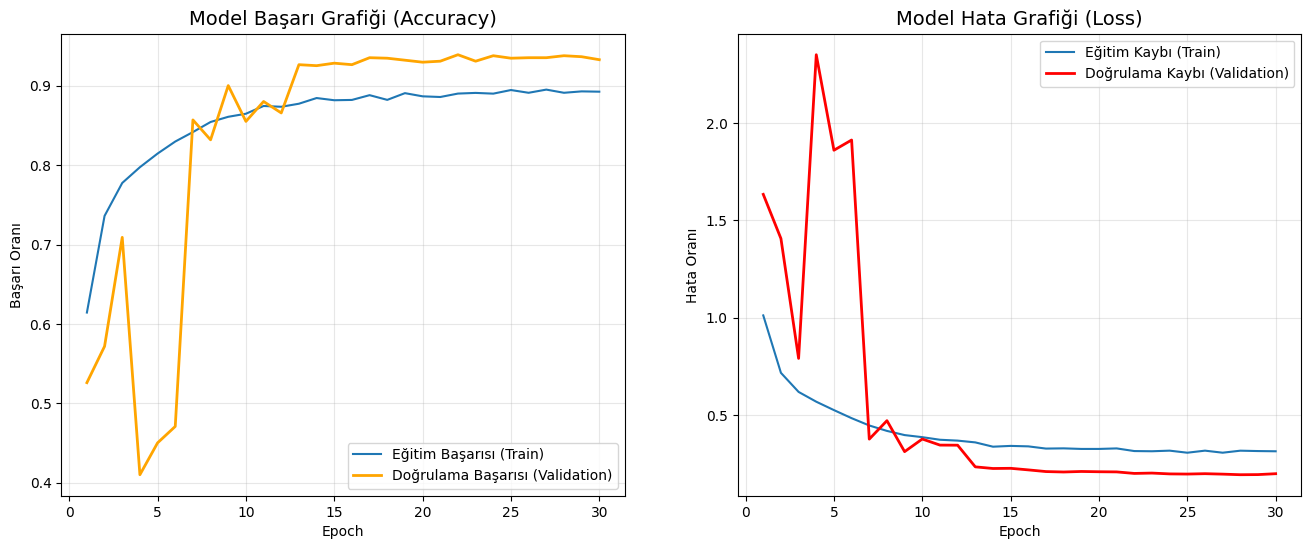


🏆 En iyi model yükleniyor ve test ediliyor...


Found 1595 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step


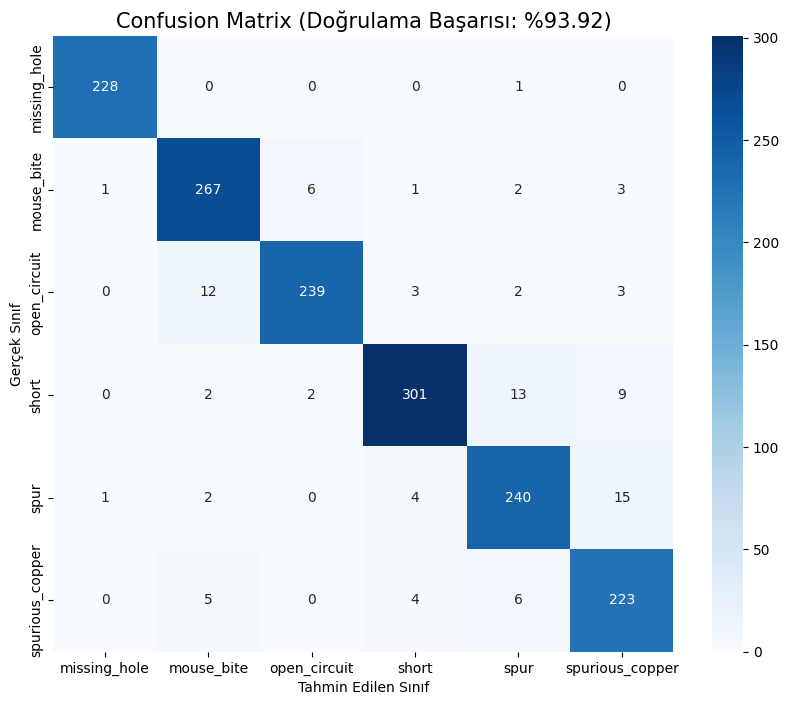


--- DETAYLI SINIFLANDIRMA RAPORU ---
                 precision    recall  f1-score   support

   missing_hole       0.99      1.00      0.99       229
     mouse_bite       0.93      0.95      0.94       280
   open_circuit       0.97      0.92      0.94       259
          short       0.96      0.92      0.94       327
           spur       0.91      0.92      0.91       262
spurious_copper       0.88      0.94      0.91       238

       accuracy                           0.94      1595
      macro avg       0.94      0.94      0.94      1595
   weighted avg       0.94      0.94      0.94      1595



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))

# Başarı Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Başarısı (Train)')
plt.plot(epochs_range, val_acc, label='Doğrulama Başarısı (Validation)', color='orange', linewidth=2)
plt.title('Model Başarı Grafiği (Accuracy)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Başarı Oranı')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Train)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation)', color='red', linewidth=2)
plt.title('Model Hata Grafiği (Loss)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Hata Oranı')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# KARMAŞIKLIK MATRİSİ
print("\n🏆 En iyi model yükleniyor ve test ediliyor...")
# Drive'daki en yüksek skorlu modeli çekiyoruz
model = load_model("/content/drive/MyDrive/pcb_resnet_finetuned.h5")

val_dir = '/content/resnet_data/val'
val_datagen = ImageDataGenerator(rescale=1./255)

# Shuffle=False kritik önemde!
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', shuffle=False
)

# Tahmin
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Matris Çizimi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Doğrulama Başarısı: %{100*np.max(val_acc):.2f})', fontsize=15)
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# Rapor
print("\n--- DETAYLI SINIFLANDIRMA RAPORU ---")
print(classification_report(y_true, y_pred, target_names=class_names))